In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import pprint
import pickle
import json
import os, sys
os.chdir("../")
sys.path.append('src/')
from util import *
from train import train_instances

# Monolithic and RA results

In [2]:
def plot_line(value, label, color, ax, fontsize):
    ax.text(5, value, label, {"fontsize": fontsize})
    ax.axhline(y=value, color=color, linestyle="-")
    
def process_df(df, window_size=30, base=20):
    df["best transitions"] = df["expanded transitions"].cummin()
    df["rounded idx"] = df["idx"].apply(lambda idx : idx // base * base if idx < 100 else 100 - base)
    #df = df.loc[df["idx"] <= (df["rounded idx"].max()-1)*window_size]
    if len(df) < 30:
        window_size = 10
    df["training steps"] = df["idx"]*50000
    df["mean transitions"] = list(np.convolve(list(df["expanded transitions"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
    df["expanded transitions"] = df["expanded transitions"].fillna(df["expanded transitions"].max()+10)
    df["instance"] = df.apply((lambda r: (r["problem"], r["n"], r["k"])), axis=1)
    df["total transitions"] = df.apply(lambda r: monolithic_results["expanded transitions", r["problem"]][r["k"]][r["n"]], axis=1)
    df["expanded transitions / total"] = df["expanded transitions"] / df["total transitions"]
    df["mean transitions / total"] = df["mean transitions"] / df["total transitions"]
    return df

# Comparing transitions

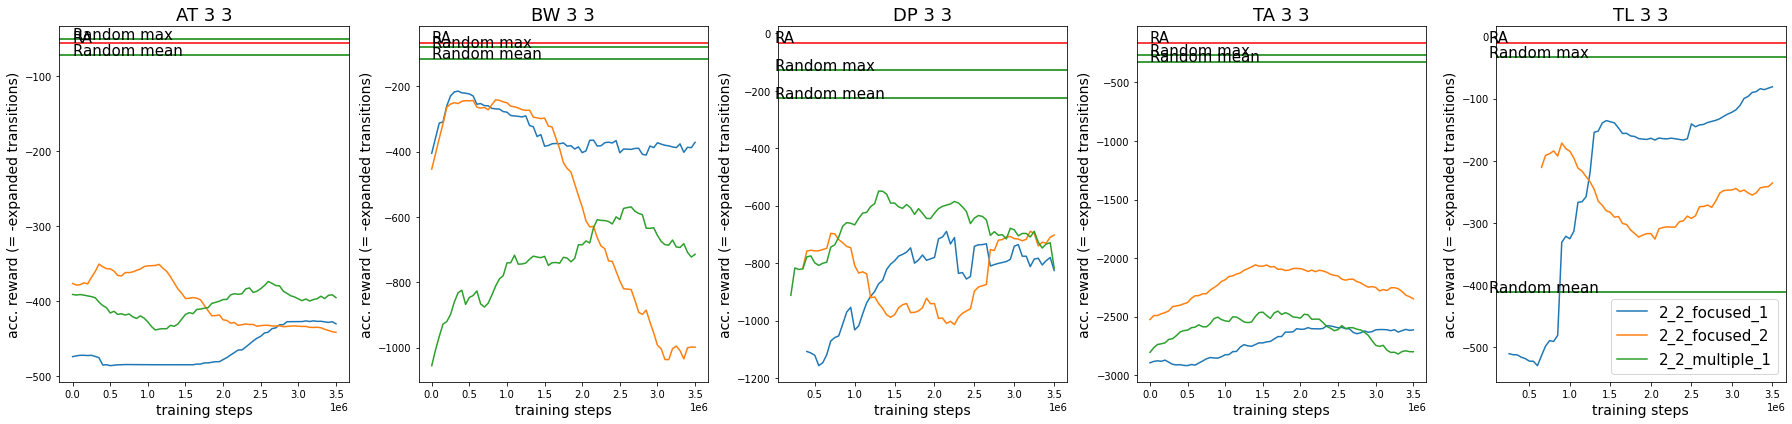

In [5]:
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10) 

problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
#problems = ["AT", "BW", "DP", "TA"]

n2, k2 = 3, 3
if n2 == 3:
    problems = [p for p in problems if p != "CM"]

files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L", "5mill_C", "5mill_SL20", "5mill_JE", "5mill_JE20"]
old_files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L"]
files = ["5mill_RA", "5mill_L", "5mill_C", "5mill_SL20", "5mill_JE20", "RR"]
files = ["5mill_JE20", "5mill_JE_D", "5mill_RR10k_D", "5mill_RR10k_D_N", "5mill_RR10k_N"]
files = ["5mill_JE20", "5mill_JE_NORA", "5mill_RR10k_NORA", "5mill_RR10k_D_N", "5mill_RR10k_NORA_1"]
files = ["focused_1", "focused_2", "multiple_1"]

f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

for i in range(len(problems)):
    problem = problems[i]
    dfs = []
    for n, k, file  in [(2, 2, f) for f in files]:
        try:
            if file in old_files:
                df = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/"+filename([problem, n2, k2])+".csv")
            else:
                df = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/generalization_all.csv")
                df = df.loc[(df["n"]==n2)&(df["k"]==k2)]
            
            df = process_df(df)
            df["case"] = filename([n, k, file])
            dfs.append(df)
        except:
            pass
        
    df = pd.concat(dfs, ignore_index=True)
    df["acc. reward (= -expanded transitions)"] = -df["mean transitions"]
    sns.lineplot(data=df, x="training steps", y="acc. reward (= -expanded transitions)", hue="case", ax=axs[i], ci=None)
    #axs[i].set_ylim((0, 1))
    
    ra = ra_results["expanded transitions", problems[i]][2][2]
    random_min = min(random_results_small[(problems[i], 2, 2)])
    random_mean = np.mean(random_results_small[(problems[i], 2, 2)])
    plot_line(-ra, "RA", "red", axs[i], 15)
    plot_line(-random_min, "Random max", "green", axs[i], 15)
    plot_line(-random_mean, "Random mean", "green", axs[i], 15)
    if i != len(problems)-1:
        axs[i].get_legend().remove()
    axs[i].set_title(" ".join([problem, str(n2), str(k2)]), fontdict={"fontsize": 18})

handles, labels = axs[0].get_legend_handles_labels()
plt.legend(handles, labels, prop={'size': 15}, loc="lower right")
plt.tight_layout()
plt.savefig("experiments/figures/NORA/tmp.jpg")
plt.show()

## Plotting training performance

In [ ]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

def read_training_data(problem, file, multiple):
    with open("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/training_data.pkl", "rb") as f:
        training_data, agent_params, env_params = pickle.load(f)    
    df = pd.DataFrame(training_data)
    df["idx"] = df["training steps"] // 10000
    df["case"] = file
    df["problem"] = problem
    if multiple:
        instances = train_instances(problem)
        df["n"] = df.apply(lambda r: instances[int(r["idx"]) % len(instances)][0], axis=1)
        df["k"] = df.apply(lambda r: instances[int(r["idx"]) % len(instances)][1], axis=1)
    else:
        df["n"] = 2
        df["k"] = 2
        df["problem"] = problem
    return df

files = [("multiple_1", True), ("focused_1", False)]
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]

f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

for i in range(len(problems)):
    dfs = []
    for file, multiple in files:
        try:
            df = read_training_data(problems[i], file, multiple)
            df = process_df(df, window_size=50)
            df["multiple"] = multiple
            df['norm transitions'] = df.groupby('total transitions')["expanded transitions"].apply(lambda x: (x - x.mean()) / x.std())
            dfs.append(df)
        except:
            pass
        
    df = pd.concat(dfs, ignore_index=True)
    #print(list(df["total transitions"]))
    df["acc. reward (= -expanded transitions)"] = -df["expanded transitions"]
    df["normalized acc. reward (= -normalized expanded transitions)"] = -df["norm transitions"]
    sns.lineplot(data=df, x="training steps", y="normalized acc. reward (= -normalized expanded transitions)", hue="case", hue_order=["focused_1", "multiple_1"], ax=axs[i], alpha=0.6)
    
    mean = df.loc[~df["multiple"]]["expanded transitions"].mean()
    std = df.loc[~df["multiple"]]["expanded transitions"].std()
    
    ra = (ra_results["expanded transitions", problems[i]][2][2] - mean) / std
    random_min = (min(random_results_small[(problems[i], 2, 2)]) - mean) / std
    random_mean = (np.mean(random_results_small[(problems[i], 2, 2)]) - mean) / std
    plot_line(-ra, "RA", "red", axs[i], 15)
    plot_line(-random_min, "Random max", "green", axs[i], 15)
    plot_line(-random_mean, "Random mean", "green", axs[i], 15)
    if i != len(problems)-1:
        axs[i].get_legend().remove()
    if i != 0:
        axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(problems[i], fontdict={"fontsize": 18})
handles, labels = axs[0].get_legend_handles_labels()
plt.legend(handles, labels, prop={'size': 15}, loc="lower right")
plt.tight_layout()
plt.savefig("experiments/figures/NORA/training_focused_vs_multiple.jpg")

## Plot solved

AT
{'focused_1': 0, 'focused_2': 48, 'multiple_1': 65}
BW
{'focused_1': 9, 'focused_2': 6, 'multiple_1': 69}
DP
{'focused_1': 82, 'focused_2': 9, 'multiple_1': 47}
TA
{'focused_1': 92, 'focused_2': 38, 'multiple_1': 51}


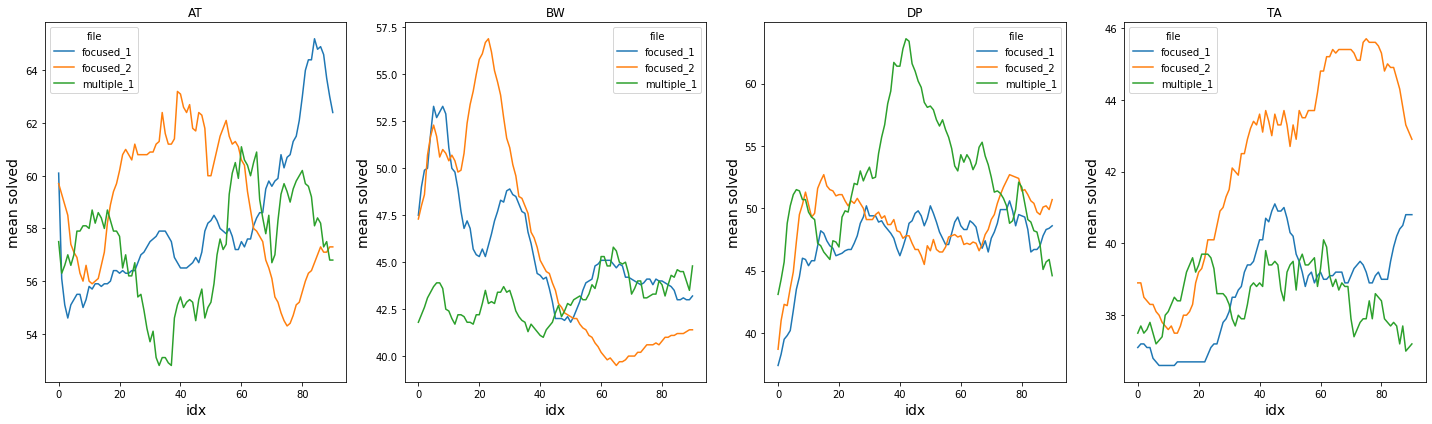

In [6]:
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
problems = ["AT", "BW", "DP", "TA"]
f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

files = ["5mill_C", "5mill_SL", "5mill_SL20", "5mill_JE", "5mill_JE20"]
files = ["5mill_JE20", "5mill_RR10k_D", "RR", "5mill_RR10k_D_N", "5mill_RR10k_N"]
files = ["5mill_JE20", "5mill_JE_NORA", "5mill_RR10k_NORA", "5mill_RR10k_D_N", "5mill_RR10k_NORA_1"]
files = ["5mill_RR10k_NORA", "5mill_RR10k_NORA_1"]
files = ["focused_1", "focused_2", "multiple_1"]#, "5mill_JE20", "5mill_RR10k_D_N"]

metric = "mean solved"
n, k = 2, 2
for i in range(len(problems)):
    problem = problems[i]
    dfs = []
    for file in files:
        df_all = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/generalization_all.csv")
        df = []
        for x, cant in dict(df_all["idx"].value_counts()).items():
            df.append({"idx": x, "solved": cant})
        df = pd.DataFrame(df)
        df.sort_values(by="idx", inplace=True)
        df["file"] = file
        window_size = 10
        df["mean solved"] = list(np.convolve(list(df["solved"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    print(problem)
    print({file: df.loc[df["file"]==file]["solved"].argmax() for file in files})
    
    sns.lineplot(data=df, x="idx", y=metric, hue="file", ax=axs[i])
    axs[i].set_title(problem)
    #axs[i].set_ylim((0, 100))
plt.tight_layout()
    
#plt.savefig("experiments/figures/NORA/"+metric+".jpg", dpi=500)
plt.show()

## 15 15 Generalization

AT 41
TA 45
BW 38
TL 20
DP 33
CM 18


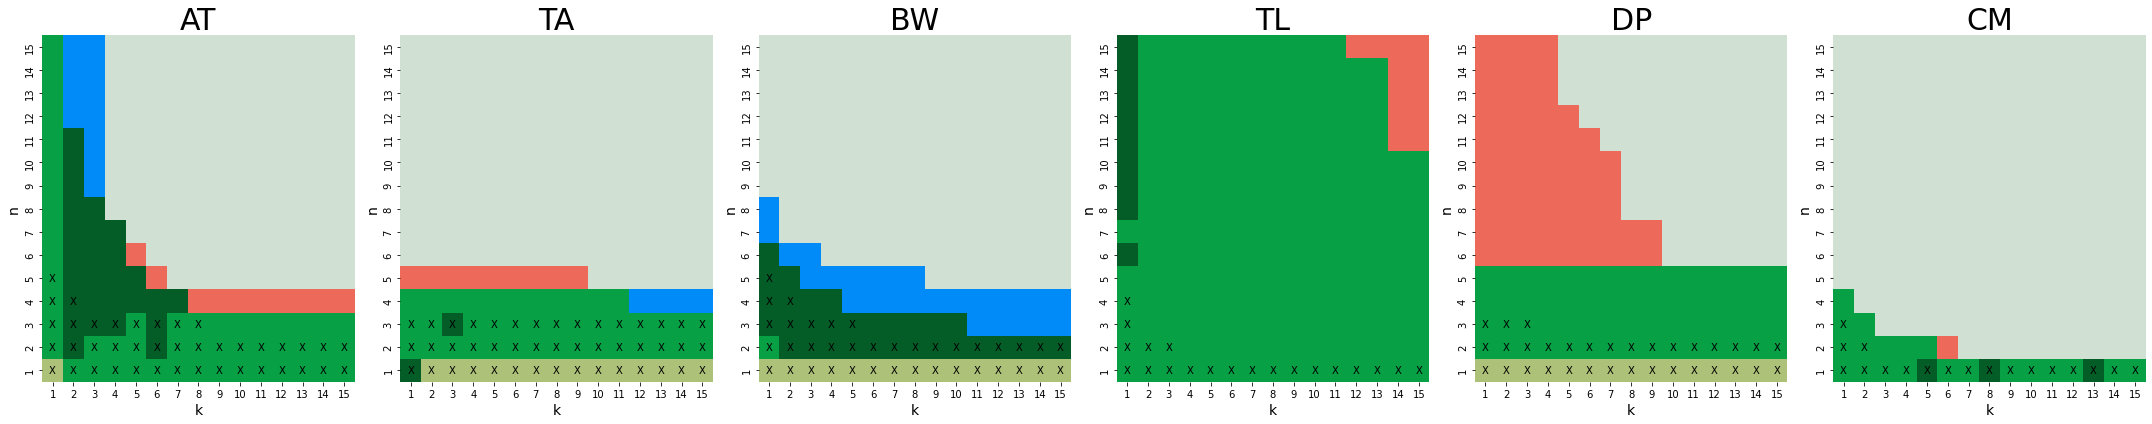

[89, 60, 73, 213, 75, 23] 533
[88, 65, 47, 225, 137, 24] 586
[38, 6, 57, 9, 0, 3] 113
[60, 49, 1, 216, 122, 21] 469


In [8]:
def get_comp_solved_df(agent, ra):
    only_ra = ((agent == float("inf")) & (ra != float("inf")))
    only_agent = ((agent != float("inf")) & (ra == float("inf")))
    both = ((agent != float("inf")) & (ra != float("inf")))
    
    return only_ra*1 + only_agent*2 + both*(3*(agent > ra) + 4*(agent == ra) + 5*(agent < ra))

metric = "expanded transitions"
#df1 = lambda problem: df_agent(problem, "all_ra_afterfix_15.csv")
#df1 = lambda problem: df_agent(problem, "5mill_JE20/all.csv")
df1 = lambda problem: df_agent(problem, "focused_2/all.csv", metric=metric)
#df1 = lambda problem: df_agent(problem, "5mill_RR10k_NORA/all.csv", metric=metric)
#df1 = lambda problem: df_agent(problem, "RR/all.csv")
#df1 = lambda problem: df_agent(problem, "all_e_15.csv")
#df1 = lambda problem: df_agent(problem, "all_random1.csv")
#df1 = lambda problem: df_agent(problem, "all_open_15.csv")
#df1 = lambda problem: df_comp(problem, ra_results)


#df2 = lambda problem: df_agent(problem, "all_ra_old_15_old.csv")
#df2 = lambda problem: df_agent(problem, "RR/all.csv")
#df2 = lambda problem: df_agent(problem, "RR/all.csv", metric=metric)
#df2 = lambda problem: df_agent(problem, "5mill_JE20/all.csv", metric=metric)
#df2 = lambda problem: df_agent(problem, "5mill_JE_NORA/all.csv", metric=metric)
#df2 = lambda problem: df_agent(problem, "5mill_RR10k_D_N/all.csv", metric=metric)
#df2 = lambda problem: df_agent(problem, "focused_1/all.csv", metric=metric)
#df2 = lambda problem: df_agent(problem, "5mill_RR10k_N/all.csv")
#df2 = lambda problem: df_agent(problem, "all_random.csv")
#df2 = lambda problem: df_comp(problem, random_results)
df2 = lambda problem: df_comp(problem, ra_results, metric=metric)
#df2 = lambda problem: df_comp(problem, monolithic_results, metric=metric)

#print(df1("DP"))
#print(df2("DP"))

problems = ["AT", "TA", "BW", "TL", "DP", "CM"]
#problems = ["AT", "BW", "DP", "TA"]
f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))
s1 = []
s2 = []
df1w = []
df2w = []
for i in range(len(problems)):
    
    grey = "#d0e1d4"
    red = "#ed6a5a"
    blue = "#008bf8"
    green = "#08a045"
    green1 = "#adc178"
    green2 = "#045c27"
    df1p = df1(problems[i])
    df2p = df2(problems[i])
    s1.append(np.sum([df1p[n][k] != float("inf") for n in range(1, 16) for k in range(1, 16)]))
    s2.append(np.sum([df2p[n][k] != float("inf") for n in range(1, 16) for k in range(1, 16)]))
    df1w.append(np.sum([df1p[n][k] < df2p[n][k] for n in range(1, 16) for k in range(1, 16)]))
    df2w.append(np.sum([df2p[n][k] < df1p[n][k] for n in range(1, 16) for k in range(1, 16)]))
    sns.heatmap(data=get_comp_solved_df(df1(problems[i]), df2(problems[i])), cmap=[grey, red, blue, green, green1, green2], vmin=0, vmax=5, ax=axs[i], cbar=False)
    
    print(problems[i], len(train_instances(problems[i])))
    for n, k in train_instances(problems[i]):
        axs[i].text(k - 0.5, n - 0.5, "X",
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
    
    axs[i].invert_yaxis()
    axs[i].set_title(problems[i], fontsize=30)

plt.tight_layout()
#plt.savefig("experiments/figures/NORA/NORA_vs_RA.jpg", dpi=200)
plt.show()
print(s1, np.sum(s1))
print(s2, np.sum(s2))
print(df1w, np.sum(df1w))
print(df2w, np.sum(df2w))


## Solved table

In [10]:
def pivot_table_to_rows(df):
    newdf = []
    for n in range(1, 16):
        for k in range(1, 16):
            newdf.append({"expanded transitions": df[k][n], "k": k, "n": n})
    return pd.DataFrame(newdf)
metric = "expanded transitions"
filegroups = [(["5mill_RR10k_NORA", "multiple_1"], "multiple"), (["5mill_JE20", "focused_1", "focused_2"], "focused")]
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]

dfss = []
for i in range(len(problems)):
    dfs = []
    for files, name in filegroups:
        for file in files:
            try:
                df = pivot_table_to_rows(df_agent(problems[i], file+"/all.csv", metric=metric))
                dfs.append(df)
                dfs[-1]["file"] = file
                dfs[-1]["approach"] = name
            except:
                pass
    df_random = pivot_table_to_rows(df_comp(problems[i], random_results, metric=metric))
    df_random["approach"] = "random"
    df_random["file"] = "only file"
    df_ra = pivot_table_to_rows(df_comp(problems[i], ra_results, metric=metric))
    df_ra["approach"] = "RA"
    df_ra["file"] = "only file"
    dfss.append(pd.concat(dfs+[df_random, df_ra], ignore_index=True))
    dfss[-1]["problem"] = problems[i]
df = pd.concat(dfss, ignore_index=True)

approaches = ["focused", "multiple", "RA", "random"]
rows = [{"approach": ap} for ap in approaches]

print(approaches)
for problem in problems:
    dfp = df.loc[df["problem"] == problem]
    for j in range(len(approaches)):
        #if approaches[j] in ["random", "RA"]:
        #    print(approaches[j])
        #    print(list(dfp.loc[(dfp["approach"] == approaches[j])]["expanded transitions"]))
        g = (dfp.loc[(dfp["approach"] == approaches[j]) & (dfp["expanded transitions"] != float("inf"))])
        #print(dict(g["file"].value_counts()))
        s = np.mean(list(dict(g["file"].value_counts()).values()))
        rows[j][problem] = s

df = pd.DataFrame(rows)
df["total"] = df.apply(lambda row: np.sum([row[problem] for problem in problems]), axis=1)
df["total (AT, BW, DP, TA)"] = df.apply(lambda row: np.sum([row[problem] for problem in ["AT", "BW", "DP", "TA"]]), axis=1)

print(df.to_latex(index=False, float_format="%.2f" ))

['focused', 'multiple', 'RA', 'random']
\begin{tabular}{lrrrrrrrr}
\toprule
approach &    AT &    BW &    CM &     DP &    TA &     TL &  total &  total (AT, BW, DP, TA) \\
\midrule
 focused & 90.00 & 69.33 & 23.67 &  78.00 & 59.33 & 212.00 & 532.33 &                  296.67 \\
multiple & 94.00 & 59.00 &   NaN &  90.50 & 59.50 &    NaN &    NaN &                  303.00 \\
      RA & 88.00 & 47.00 & 24.00 & 137.00 & 65.00 & 225.00 & 586.00 &                  337.00 \\
  random & 72.00 & 48.00 & 22.00 &  47.00 & 51.00 &  58.00 & 298.00 &                  218.00 \\
\bottomrule
\end{tabular}



## 15 15 Generalization average

In [ ]:
def get_max_n_curve(df):
    max_n = []
    for k in range(1, 16):
        max_n.append(np.sum(df[k] != float("inf")))
    return pd.DataFrame({"k": np.arange(1, 16), "max n": max_n})
    

metric = "expanded transitions"

filegroups = [(["5mill_RR10k_NORA", "multiple_1"], "multiple"), (["5mill_JE20", "focused_1"], "focused")]

problems = ["AT", "BW", "CM", "DP", "TA", "TL"]

f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

for i in range(len(problems)):
    dfs = []
    for files, name in filegroups:
        for file in files:
            try:
                df = df_agent(problems[i], file+"/all.csv", metric=metric)
                dfs.append(get_max_n_curve(df))
                dfs[-1]["file"] = file
                dfs[-1]["approach"] = name
            except:
                pass
    df_random = get_max_n_curve(df_comp(problems[i], random_results, metric=metric))
    df_random["approach"] = "random"
    df_ra = get_max_n_curve(df_comp(problems[i], ra_results, metric=metric))
    df_ra["approach"] = "RA"
    
    df = pd.concat(dfs+[df_ra, df_random], ignore_index=True)
    
    sns.lineplot(data=df, x="k", y="max n", hue="approach", ax=axs[i], ci=None, marker="o")
    axs[i].set_ylim((0, 16))
    axs[i].set_xlim((0, 16))
    axs[i].set_title(problems[i])

plt.tight_layout()
#plt.savefig("experiments/figures/NORA/NORA_vs_RA.jpg", dpi=200)
plt.show()

# Comparing avg Q

In [ ]:
#problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
problems = ["AT", "BW", "DP", "TA"]

files = ["5mill_RA", "5mill_L", "5mill_C", "5mill_SL20", "5mill_JE20", "5mill_JE_NORA"]
#files = ["5mill_JE20", "RR", "5mill_RR10k_D", "5mill_RR10k_N", "5mill_RR10k_D_N"]
files = ["5mill_JE20", "5mill_JE_NORA", "focused_1", "multiple_1", "5mill_RR10k_NORA"]

f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

for i in range(len(problems)):
    dfs = []
    for file in files:
        dfs.append(pd.read_csv("experiments/results/"+filename([problems[i], n, k])+"/"+file+"/q.csv"))
        dfs[-1]["file"] = file
    df = pd.concat(dfs, ignore_index=True)
    df["avg q"] = -df["avg q"]
    sns.lineplot(data = df, x="training steps", y="avg q", hue="file", ax=axs[i])
    
    axs[i].set_title(problems[i])
#plt.savefig("experiments/figures/q.jpg", dpi=200)
plt.show()

# Analyzing models output

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
from statsmodels.regression.linear_model import OLS

a = 0
def plot_q_and_pred(m, df_features, features, problem):
    print(problem, m.rank_, m.intercept_)
    print(m.coef_)
    print(m.score(df_features[features], df_features["q"]))
    print(df_features["q"].min(), df_features["q"].max())
    df_features["pred"] = m.predict(df_features[features])
    df_features["pred"].plot(kind="hist")
    plt.title(("pred", problem))
    plt.show()
    plt.title("q")
    df_features["q"].plot(kind="hist")
    plt.title(("q", problem))
    plt.show()

def plot_features(problem, n, k, dir):
    df_features = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/best.csv")
    
    features = feature_names(get_agent_info(agent_path(filename([problem, n, k]) + "/" + file, 0)), problem)
    #print(features)
    #m = LinearRegression()
    #m.fit(df_features[features], df_features["q"])
    #plot_q_and_pred(m, df_features, features, problem)
    
    constant_filter = VarianceThreshold(threshold=0)
    constant_filter.fit(df_features[features])
    constant_columns = [column for column in df_features[features].columns if column not in df_features[features].columns[constant_filter.get_support()]]
    print("Constant columns: ", constant_columns)
    X = df_features[features].loc[:, constant_filter.get_support()]
    #fvalues, pvalues = f_regression(X, df_features["q"])
    #print(fvalues.shape, pvalues.shape)
    # df_features["q"] = (df_features["q"] - df_features["q"].mean()) / df_features["q"].std()
    m = OLS(df_features["q"], X)
    r = m.fit()
    #print(r.params)
    plt.xticks(ha='right', rotation=55, fontsize=6)
    sns.barplot(x=X.columns, y=r.params)
    plt.title((problem, n, k))
    #plt.savefig("experiments/figures/NORA/features/"+filename(["features", file, problem])+".jpg", dpi=400, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    

problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
#file = "5mill_JE20"
#problems = ["AT", "BW", "DP", "TA"]
file = "5mill_JE_NORA"
for problem, n, k in [(x, 2, 2) for x in problems]:
    plot_features(problem, n, k, file)

In [ ]:
problem, n, k = "CM", 2, 2
last = False
ra_feature = True
dir = "ra_feature_2h"

problem2, n2, k2 = (problem, 3, 3) if problem != "CM" else (problem, 2, 2)
df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/"+filename([problem2, n2, k2])+".csv")
idx = best_agent_idx(df) if not last else last_agent_idx(df)
t = "last" if last else "best"
df_features = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/"+t+"_"+str(idx)+".csv")

m = LinearRegression()
m.fit(df_features[feature_names(ra_feature)], df_features["q"])
features = feature_names(ra_feature)
print(problem, m.rank_, m.intercept_)
print(m.coef_)
print(m.score(df_features[feature_names(ra_feature)], df_features["q"]))
df_features["pred"] = m.predict(df_features[feature_names(ra_feature)])

In [ ]:
[]
print(np.dot(m.coef_, [ for i in range(14)])+m.intercept_)

# Q Distribution

In [ ]:
from sklearn.linear_model import LinearRegression

def plot_features(problem, n, k, dir, last=False, ra_feature=True):
    problem2, n2, k2 = (problem, 3, 3) if problem != "CM" else (problem, 2, 2)
    df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/"+filename([problem2, n2, k2])+".csv")
    idx = best_agent_idx(df) if not last else last_agent_idx(df)
    t = "last" if last else "best"
    df_features = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/"+t+"_"+str(idx)+".csv")
    
    df_features["q"].plot(kind='hist');
    plt.title((problem, n, k))
    #plt.savefig("experiments/figures/2h/"+t+"_features/"+filename([problem, n, k, t, ra_feature])+".jpg", dpi=200, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    

problems = ["AT", "TA", "TL", "DP", "BW", "CM"]
for problem, n, k in [(x, 2, 2) for x in problems]:
    plot_features(problem, n, k, "ra_feature_2h", last=False, ra_feature=True)
    #plot_features(problem, n, k, "ra_feature_2h", last=False, ra_feature=False)
    #plot_features(problem, n, k, "ra_feature_2h", last=True, ra_feature=True)
    #plot_features(problem, n, k, "ra_feature_2h", last=True, ra_feature=False)

## Feature distribution

In [ ]:
n = 2
states_file = "states_context.pkl"
dfs = []
problems = ["AT", "BW", "DP", "TA", "TL", "CM"]
for problem in problems:
    features = feature_names({"ra feature": True, "context features": True}, problem)
    df = {name: [] for name in features}
    with open("experiments/results/"+filename([problem, n, n])+"/"+states_file, "rb") as f:
        states = pickle.load(f)
    for s in states:
        for a in s:
            for i in range(len(features)):
                df[features[i]].append(a[i])
    df = pd.DataFrame(df)
    df["problem"] = problem
    dfs.append(df)
    print(problem, df["in open"].sum(), df["in open"].sum() / df.shape[0])

df = pd.concat(dfs, ignore_index=True)

In [ ]:
print(df.columns)

In [ ]:
print(((df["action controllable"] > 0.5) & (df["ra type best"] > 0.75)).sum())

In [ ]:
problem = "TL"
dfp = df.loc[df["problem"] == problem]
features = feature_names({"ra feature": True, "context features": True}, problem)
for name in features:
    dfp[name].plot(kind='hist');
    plt.title((name, problem))
    plt.show()

## Analyzing nn weights

In [ ]:
import onnx
from onnx import numpy_helper

weights = []
for idx in range(100):
    onnx_model = onnx.load("experiments/results/AT_3_3/5mill/" + str(idx)+".onnx")
    INTIALIZERS  = onnx_model.graph.initializer
    onnx_weights = {}
    for initializer in INTIALIZERS:
        W = numpy_helper.to_array(initializer)
        onnx_weights[initializer.name] = W
    w = onnx_weights["coefficient"]
    if True:
        for key, value in onnx_weights.items():
            if key == "coefficient1":
                print(key, value.min(), value.max())
    for feature in range(w.shape[0]):
        for node in range(w.shape[1]):
            weights.append({"t": idx, "val": w[feature, node], "feature": feature, "node": node})
    
weights = pd.DataFrame(weights)

In [ ]:
for feature in range(23):
    print(feature_names({"ra feature": True}, "AT")[feature])
    df = weights.loc[weights["feature"] == feature]
    sns.lineplot(data=df, x="t", y="val", hue="node")
    plt.show()